In [2]:
import pandas as pd
import numpy as np
import json
import dask.bag as db
import dask.dataframe as dd
import tensorflow as tf
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

2024-08-27 11:42:12.310260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Table of Contents
[Step 0](#part0) The statement of the problem <br>
[Step 1](#part1) From bres select impressions with sflr == 15 <br>
[Step 2](#part2) Extract relevant fields from the raw bres  with sflr == 15: resulting file 'processed_bres_15_date.pkl' <br>
[Step 3](#part3) Extract relevant fields form om file. Mark those impressions in bres that are in om with Y or N depending on whether the bid was successful or not <br>
[Step 4](#part4) Plot the data, zero in on the floor price bids  <br>
[Step 5](#part5) Clean the resulting dataframe
    a. convert time to hourly slots
    b. cleanup the text /categories in the columns <br>
[Step 6](#part6) Split the dataframe into two:  sbpr = 15 and sbpr != 15 <br>
[Step 7](#part7). Use sbpr = 15 for classification. <br>
[Step 8](#part8) Based on the model in Step 6 predict which impressions should not be in sbpr != 15 dataframe. Eliminate those from the dataframe <br>
[Step 9](#part9) Plot the learned probability.

Step 0: The statement of the problem and summary of the results. <br>
<a id="part0"></a>


The problem comes from the world of real-time bidding in advertising. To simplify for the purposes of this short POC, a platform submits bids for ads (impressions), following some strategy. Some of these bids get accepted and the question is how to optimize the strategy. 
More specifically, each impression is submitted with a floor price 'sflr' and the platform places bids at prices 'sbpr' $>=$ 'sflr'. In the ideal world one expects the probability of the bid being accepted to be a monotonically increasing function the bid price 'sbpr'. 
However, as the plot below shows this is totally not the case. In this example I'm displaying the probability for a single 'sflr'$=$15.0 for one day.

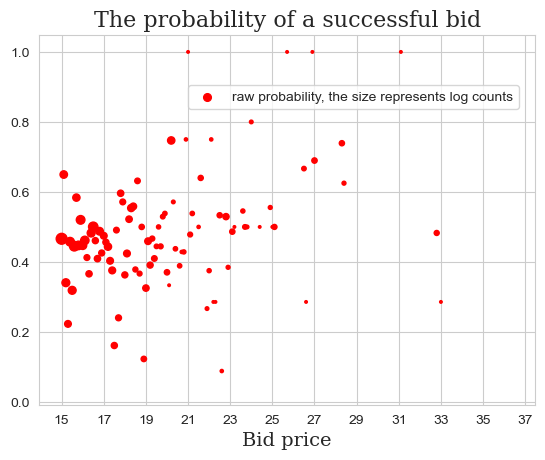

In [19]:
fig_prob

Several things jump out from the figure:
1. there are lots of bids at the floor price.
2. there are bid prices with 100% probability of winning.

Step 1: Extraction of data from the submitted bids 'bres' and accepted bids 'om' files.
<a id="part1"></a>

Start with the submitted bids, will take the data for one, and only one floor price 'sflr' $=$ 15

In [22]:
df_0409 = dd.read_json('bres_0409.json', blocksize="128 MiB", lines=True) # load the json file

In [254]:
df_0409.head() # take a look

,level,demand_partner,opn,dbpr,sbpr,dflr,sflr,publisher_id,kgrp,bidrequest,bidresponse,time,message
0,info,freewheel,1.1,2.250924,2.125462,2.1,2.0,18000792,c,"{""id"":""b97c3bdb-cd9d-439e-8562-4ccd52245965"",""...","{'id': 'b97c3bdb-cd9d-439e-8562-4ccd52245965',...",2024-04-09T00:00:00Z,response
1,info,freewheel,1.4,2.325414,2.000000,2.1,2.0,18000792,t,"{""id"":""1cbcb65d-1f4c-4f03-bdc6-8f92be484672"",""...","{'id': '1cbcb65d-1f4c-4f03-bdc6-8f92be484672',...",2024-04-09T00:00:00Z,response
2,info,wurl,1.4,12.000000,10.000000,10.5,10.0,109759,c,"{""id"":""78f06a03-ece8-4113-bdc5-e03d488bb32f"",""...","{'id': '78f06a03-ece8-4113-bdc5-e03d488bb32f',...",2024-04-09T00:00:00Z,response
3,info,bidswitch,3.4,17.112000,16.000000,18.4,16.0,94372221,t,"{""id"":""coa8a05itjdcn86dc5g0"",""imp"":[{""id"":""520...","{'id': 'coa8a05itjdcn86dc5g0', 'seatbid': [{'b...",2024-04-09T00:00:00Z,response
4,info,wurl,2.4,12.000000,10.000000,11.0,10.0,109759,t,"{""id"":""b2106c3b-9688-47d9-9cdc-7c57a4446e54"",""...","{'id': 'b2106c3b-9688-47d9-9cdc-7c57a4446e54',...",2024-04-09T00:00:00Z,response


In [23]:
df1_0409 = df_0409.drop(['level', 'demand_partner', 'opn', 'dbpr', 'dflr', 'kgrp', 'message','bidresponse'], axis=1)
df_raw0409_15 = df1_0409[df1_0409['sflr']== 15.0].drop(['sflr'], axis=1).reset_index(drop=True) # drop redundant fields, keep floor price $15.0 only

In [24]:
df_raw0409_15  = df_raw0409_15.compute()

In [25]:
df_raw0409_15.head()

,sbpr,publisher_id,bidrequest,time
0,15.0,650003,"{""id"":""51821639-48a2-447b-b5de-aee0beb878bd"",""...",2024-04-09T00:00:01Z
1,15.0,650003,"{""id"":""5aa54938-a3a7-447b-b6cf-14b43764f8e3"",""...",2024-04-09T00:00:01Z
2,15.0,650003,"{""id"":""37b89a1e-e9e3-4697-a7f9-e20f0906fd30"",""...",2024-04-09T00:00:02Z
3,16.5,650003,"{""id"":""ee6d522b-838e-4ecd-bb10-71637c4b0505"",""...",2024-04-09T00:00:03Z
4,15.0,650003,"{""id"":""97253b20-00e5-445c-90c0-8cdf19da12c6"",""...",2024-04-09T00:00:03Z


In [30]:
def process(df_raw):
    """ 1. input a raw file; output a processed file
    2. extract features from bidrequest
    3. add sbpr and time from the raw file
    4. drop publisher_id and bidrequest columns
    5. add tod column, do not drop time column"""
    def extract_features_row(df_row):
        d1 = {k:v for k,v in json.loads(df_row.bidrequest).items() if k not in ['source','at','tmax','user','regs']}
        d2 = {}
        d2['id'] = d1['id']
        if 'minduration' in d1['imp'][0]['video'].keys():
            d2['minduration'] = d1['imp'][0]['video']['minduration']
        else: d2['minduration'] = np.nan
        d2['maxduration'] = d1['imp'][0]['video']['maxduration']
        d2['minbitrate']= d1['imp'][0]['video']['minbitrate']
        d2['maxbitrate']= d1['imp'][0]['video']['maxbitrate']  
        if 'app' in d1.keys():
            if 'id' in d1['app'].keys():
                d2['app_id'] = d1['app']['id']
            else: d2['app_id'] = np.nan
            if 'name' in d1['app'].keys():
                d2['app_name'] = d1['app']['name']
            else: d2['app_name'] = np.nan
            if 'bundle' in d1['app'].keys():
                d2['app_bundle'] = d1['app']['bundle']
            else: d2['app_bundle'] = np.nan
            d2['app_pub_id'] = d1['app']['publisher']['id']
            if 'content' in d1['app'].keys():
                if 'genre' in d1['app']['content'].keys():
                    d2['genre'] = d1['app']['content']['genre']
                else: d2['genre'] = np.nan
                if 'language' in d1['app']['content'].keys():
                    d2['language'] = d1['app']['content']['language']
                else: d2['language'] = np.nan
            else: d2['genre'] = d2['language'] = np.nan
        else: d2['app_id'] = d2['app_bundle']= d2['app_pub_id'] = d2['genre'] = d2['language'] = np.nan
        d2['device_make'] = d1['device']['make']
        if 'model' in d1['device'].keys():
            d2['device_model'] = d1['device']['model']
        else: d2['device_model'] = np.nan
        if 'os' in d1['device'].keys():
            d2['device_os'] = d1['device']['os']
        else: d2['device_os'] = np.nan
        if 'language' in d1['device'].keys():
            d2['device_language'] = d1['device']['language']
        else: d2['device_language'] = np.nan
        if 'geo' in d1['device'].keys() and 'region' in d1['device']['geo'].keys():
            d2['geo_region'] = d1['device']['geo']['region']
        else: d2['geo_region'] = np.nan
        if 'geo' in d1['device'].keys() and 'metro' in d1['device']['geo'].keys():
            d2['geo_metro'] = d1['device']['geo']['metro']
        else: d2['geo_metro'] = np.nan
        return d2
    applied_df = df_raw.apply(lambda row: extract_features_row(row), axis='columns', result_type='expand')
    df_proc_15 = pd.concat([df_raw, applied_df], axis='columns').drop(['publisher_id', 'bidrequest'], axis=1)
    # time_df = pd.to_datetime(df_proc_15.time).dt.hour
    # df_proc_15 = df_proc_15.assign(time=time_df)
    #df_proc_15.drop('time', axis=1, inplace=True)
    # drop device_language as it's always en
    if df_proc_15['device_language'].nunique() == 1:
        df_proc_15.drop('device_language', axis=1, inplace=True)
    # convert all strings to lower case
    for column in df_proc_15.columns:
        if df_proc_15[column].dtype == 'object':
            df_proc_15[column] = df_proc_15[column].str.lower() 
    return df_proc_15

In [31]:
df_ex0409_15 = process(df_raw0409_15)
df_ex0409_15.head()

,sbpr,time,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,language,device_make,device_model,device_os,geo_region,geo_metro
0,15.0,0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,sc,546
1,15.0,0,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,1034,NaN,NaN,generic,generic android tv,android,oh,NaN
2,15.0,0,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,tn,691
3,16.5,0,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524
4,15.0,0,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524


In [290]:
df_ex0409_15.nunique()

sbpr              2893
time                24
id              544228
minduration          5
maxduration         93
minbitrate           3
maxbitrate           6
app_id             411
app_name           233
app_bundle         319
app_pub_id           9
genre             1310
language            13
device_make         82
device_model       838
device_os            9
geo_region          80
geo_metro          230
dtype: int64

In [291]:
df_ex0409_15.info

<bound method DataFrame.info of            sbpr  time                                    id  minduration  \
0     15.000000     0  51821639-48a2-447b-b5de-aee0beb878bd            1   
1     15.000000     0  5aa54938-a3a7-447b-b6cf-14b43764f8e3            1   
2     15.000000     0  37b89a1e-e9e3-4697-a7f9-e20f0906fd30            1   
3     16.500000     0  ee6d522b-838e-4ecd-bb10-71637c4b0505            1   
4     15.000000     0  97253b20-00e5-445c-90c0-8cdf19da12c6            1   
...         ...   ...                                   ...          ...   
6683  15.000000    23  2ac8cea8-7284-4649-adb1-572cb89e5142            1   
6684  15.220674    23  4094145f-1bcb-46e5-8f14-6f26ab8a1fdd            1   
6685  15.600000    23  1d33c229-9c0c-4efd-ad20-c609d486a78e            1   
6686  15.000000    23  77df0a7c-89a8-4327-b27f-f535483741b3            1   
6687  15.000000    23  03951cba-c2cf-481b-aee5-c92956c21181            1   

      maxduration  minbitrate  maxbitrate  app_id  \
0 

In [42]:
df_ex0409_15 = df_ex0409_15.drop_duplicates(subset=['id'], keep='first') #Remove entries with duplicate ids

In [293]:
"""this concludes the cleaning of the submitted bids file"""
df_ex0409_15.to_pickle("bres_0409_15_clean")

Step 2. Continue with extracting data from the accepted bids file.
<a id="part2"></a>

In [35]:
om_raw = pd.read_json('om_0409.json', lines=True)

FileNotFoundError: File om_0409.json does not exist

In [69]:
om_raw.head()

,level,fields,time,message
0,info,{'_om': ['LhYGClQLOAYBGwgmHBdLLB0EQQgKOBcIVAk8...,2024-04-09T00:00:02Z,om-imp
1,info,{'_om': ['LhYGClQeIQQKDBUuABALKgEaSQoBIEMFDRQ6...,2024-04-09T00:00:04Z,om-imp
2,info,{'_om': ['LhYGClQbIwgHRwQsHEIEKwcbC1RFZk5PQkpj...,2024-04-09T00:00:05Z,om-imp
3,info,{'_om': ['LhYGClQDLAsBCwhmCgsIaRMNEhsCcE5PQkpj...,2024-04-09T00:00:09Z,om-imp
4,info,{'_om': ['LhYGCVRfawQAHBMkVAwROwIaQlovaFciTFMO...,2024-04-09T00:00:10Z,om-imp


In [71]:
om_raw.columns

Index(['level', 'fields', 'time', 'message'], dtype='object')

In [72]:
om_raw.drop(['level', 'time', 'message'], axis=1, inplace=True)

In [73]:
def clean_om(row):
    d = {}
    for k,v in row.fields.items():
        if k == 'bdid':
            d[k] = v[0]
        if k == 'sflr':
            d[k] = float(v[0])
        if k == 'sbpr':
            d[k] = float(v[0])
    return d

In [74]:
om_clean_0409 = om_raw.apply(clean_om, axis=1, result_type='expand')

In [248]:
om_clean_0409[om_clean_0409.sflr == 15.0].nunique()

bdid    253161
sbpr      1414
sflr         1
dtype: int64

In [250]:
len(om_clean_0409[om_clean_0409.sflr == 15.0])

268932

In [76]:
om_clean_0409.to_pickle('om_clean_0409.pkl')

In [6]:
om_clean_0409= pd.read_pickle("om_clean_0409.pkl")

Now, use the successful bids from the 'om' file to mark those in the submitted bids 'bres' file.
The field 'bdid' in the 'om' file matches the field 

In [7]:
bdid_set = set(om_clean_0409[om_clean_0409.sflr == 15.0].bdid)

In [9]:
df_extr0409_15= pd.read_pickle("bres_0409_15_clean")

In [11]:
df_extr0409_15['data'] = df_extr0409_15.apply(lambda row: row.id in bdid_set, axis=1)
df_extr0409_15.head()

,sbpr,time,id,minduration,maxduration,minbitrate,maxbitrate,app_id,app_name,app_bundle,app_pub_id,genre,language,device_make,device_model,device_os,geo_region,geo_metro,data
0,15.0,0,51821639-48a2-447b-b5de-aee0beb878bd,1,120,1,280000,702131,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,sc,546,False
1,15.0,0,5aa54938-a3a7-447b-b6cf-14b43764f8e3,1,120,1,280000,711665,"sling: live tv, shows & movies",com.sling,1034,NaN,NaN,generic,generic android tv,android,oh,NaN,False
2,15.0,0,37b89a1e-e9e3-4697-a7f9-e20f0906fd30,1,120,1,280000,726329,plex,g15147002586,1034,entertainment,NaN,samsung,tizen tv,tizen,tn,691,False
3,16.5,0,ee6d522b-838e-4ecd-bb10-71637c4b0505,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524,False
4,15.0,0,97253b20-00e5-445c-90c0-8cdf19da12c6,1,70,1,280000,711667,fubotv: watch live sports & tv,905401434,1034,NaN,en,apple,tv a1625,other,ga,524,False


Step 4. Everything is ready to plot the probability of a bid to go through
<a id="part4"></a>

In [43]:
# need to round off the prices first
df_extr0409_15.sbpr = df_extr0409_15.sbpr.round(1)
df_extr0409_15.sbpr.head()

0    15.0
1    15.0
2    15.0
3    16.5
4    15.0
Name: sbpr, dtype: float64

In [45]:
df_all = pd.DataFrame(df_extr0409_15.groupby(['sbpr'])['sbpr'].count())
df_all.rename(columns={"sbpr":"total_count"}, inplace=True)
df_all.head()

,total_count
sbpr,
15.0,460402
15.1,491
15.2,1738
15.3,462
15.4,4664


In [14]:
df_true = pd.DataFrame(df_extr0409_15[df_extr0409_15.data==True].groupby(['sbpr'])['sbpr'].count())
df_true.rename(columns={"sbpr":"true_count"}, inplace=True)
df_true.head()

,true_count
sbpr,
15.0,214605
15.1,319
15.2,592
15.3,103
15.4,2135


In [46]:
df_prob = pd.concat([df_all,df_true], axis=1)
df_prob.head()

,total_count,true_count
sbpr,,
15.0,460402,214605.0
15.1,491,319.0
15.2,1738,592.0
15.3,462,103.0
15.4,4664,2135.0


In [47]:
df_prob["prob"] = df_prob.apply(lambda row: row.true_count/row.total_count, axis=1)
df_prob.head(20)

,total_count,true_count,prob
sbpr,,,
15.0,460402,214605.0,0.466125
15.1,491,319.0,0.649695
15.2,1738,592.0,0.340621
15.3,462,103.0,0.222944
15.4,4664,2135.0,0.457762
15.5,1935,617.0,0.318863
15.6,32659,14533.0,0.444992
15.7,394,230.0,0.583756
15.8,4188,1873.0,0.447230


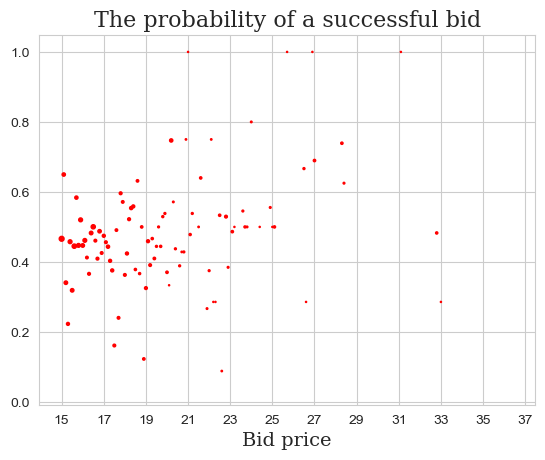

In [48]:
plt.scatter(x = df_prob.index, y= df_prob.prob, color = 'r', s = np.log(df_prob.true_count) )
plt.xticks(np.arange(15, 39, step=2))
plt.xlabel('Bid price',fontsize=14,fontfamily='serif')
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
plt.savefig('Bid probability before.png')

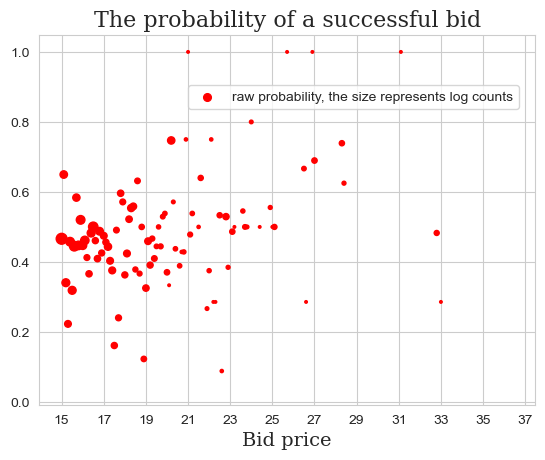

In [49]:
fig_prob, ax  = plt.subplots()
plt.title("The probability of a successful bid", fontsize=16, fontfamily='serif')
ax.scatter(x= df_prob.index, y= df_prob.prob, color = 'r' ,s = np.log(df_prob.true_count)*5)
ax.set_xlabel('Bid price',fontsize=14,fontfamily='serif')
ax.set_xticks(np.arange(15, 39, step=2))
ax.legend(['raw probability, the size represents log counts'], loc=(0.3,0.8))
plt.savefig('Bid probability before.png')


Let's see what proportion of bids actually occurs at the floor price.

In [50]:
fraction_of_all_bids = df_prob[df_prob.index == 15.0].total_count/df_prob.total_count.sum()
fraction_of_all_bids

sbpr
15.0    0.845973
Name: total_count, dtype: float64

In [52]:
fraction_of_om_bids = df_prob[df_prob.index == 15.0].true_count/df_prob.true_count.sum()
fraction_of_om_bids

sbpr
15.0    0.847866
Name: true_count, dtype: float64

Let's look at the distribution of bids at the floor price as a function of time.

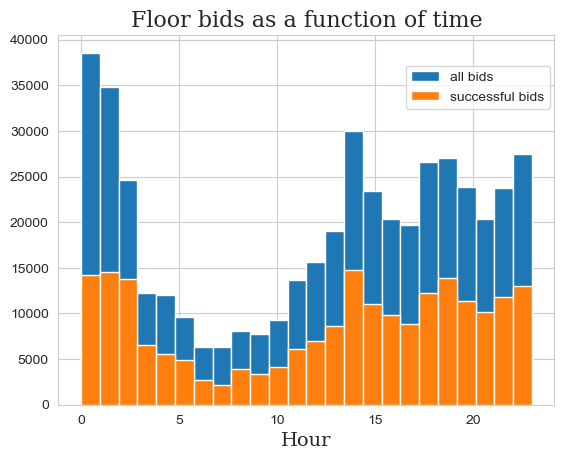

In [53]:
all_15  = df_extr0409_15[(df_extr0409_15.sbpr==15)].time
om_15 = df_extr0409_15[(df_extr0409_15.sbpr==15) & (df_extr0409_15.data==True)].time
fig_hist, axis_hist = plt.subplots(1,1)
plt.title("Floor bids as a function of time", fontsize=16, fontfamily='serif')
axis_hist.set_xlabel('Hour',fontsize=14,fontfamily='serif')
axis_hist.hist(all_15, bins=24)
axis_hist.hist(om_15, bins=24)
axis_hist.legend(['all bids','successful bids'], loc=(0.7,0.8))
plt.savefig('Floor_time')

As noted in the introduction, the current strategy seems to place bids at the floor price at random. The purpose of this project to learn which impressions should actually be bid at the floor price. In case of success, it will have two benefits:
1. The probability of winning at the floor price, i.e. at the minimal cost will increase
2. We will be able to identify impressions at other bid prices that should actually be bid at the floor price and that will remove the noise and allow us to approximate the probability curve.

Step 5. Cleaning and reparing data for classification. </br>
<a id="part0"></a>

In [37]:
df_extr0409_15.columns

Index(['sbpr', 'time', 'id', 'minduration', 'maxduration', 'minbitrate',
       'maxbitrate', 'app_id', 'app_name', 'app_bundle', 'app_pub_id', 'genre',
       'language', 'device_make', 'device_model', 'device_os', 'geo_region',
       'geo_metro', 'data'],
      dtype='object')

In [54]:
#rename the dataframe
df_15_YN = df_extr0409_15
df_15_YN.isnull().sum(axis = 0)

sbpr                 0
time                 0
id                   0
minduration          0
maxduration          0
minbitrate           0
maxbitrate           0
app_id               0
app_name           164
app_bundle          41
app_pub_id           0
genre           450479
language        222082
device_make          0
device_model         0
device_os            0
geo_region       10380
geo_metro        74213
data                 0
dtype: int64

In [55]:
df_15_YN.nunique()

sbpr               140
time                24
id              544228
minduration          5
maxduration         93
minbitrate           3
maxbitrate           6
app_id             411
app_name           233
app_bundle         319
app_pub_id           9
genre             1310
language            13
device_make         82
device_model       838
device_os            9
geo_region          80
geo_metro          230
data                 2
dtype: int64

In [61]:
len(df_15_YN)


544228

In [56]:
len(df_15_YN[df_15_YN.data == True])

253112

In [57]:
len(df_15_YN[df_15_YN.data == False])

291116

So we have a fairly balanced data set, with roughly 50:50 split between positives and negatives.

In [62]:
df_15_YN.dtypes

sbpr            float64
time              int32
id               object
minduration       int64
maxduration       int64
minbitrate        int64
maxbitrate        int64
app_id           object
app_name         object
app_bundle       object
app_pub_id       object
genre            object
language         object
device_make      object
device_model     object
device_os        object
geo_region       object
geo_metro        object
data               bool
dtype: object

 Step 5. Start cleaning the data for training
 <a id="part5"></a>

convert all text to lowercase

In [63]:
for column in df_15_YN.columns:
    if df_15_YN[column].dtype == 'object':
        df_15_YN[column] = df_15_YN[column].str.lower() 

In [64]:
df_15_YN.nunique()

sbpr               140
time                24
id              544228
minduration          5
maxduration         93
minbitrate           3
maxbitrate           6
app_id             411
app_name           233
app_bundle         319
app_pub_id           9
genre             1310
language            13
device_make         82
device_model       838
device_os            9
geo_region          80
geo_metro          230
data                 2
dtype: int64

dealing with language column

In [65]:
df_15_YN.language = df_15_YN.language.str.lower().str.replace('-', "_").str.replace('\[[^\]]*\]', 'NaN', regex=True).replace('NaN', np.nan)
df_15_YN.language.unique()

array([nan, 'en', 'es', 'english', 'en_us', 'ru', 'zh', 'ko',
       'english, japanese', 'mandarin, cantonese, english', 'th', 'ja',
       'japanese', 'yue'], dtype=object)

In [66]:
df_15_YN.groupby(['language'])['language'].value_counts().sort_values(ascending=False)

language
en                              320674
es                                 679
english                            512
zh                                 132
en_us                              120
ko                                  10
ja                                   8
th                                   4
mandarin, cantonese, english         2
yue                                  2
english, japanese                    1
japanese                             1
ru                                   1
Name: count, dtype: int64

In [67]:
#drop language as most are in en
df_15_YN.drop('language', axis=1, inplace=True)

dealing with app_id column

In [68]:
df_15_YN.groupby(['app_id'])['app_id'].value_counts().sort_values(ascending=False)

app_id
711667    248240
711665    190500
726329     27111
635564     26616
623265      7413
           ...  
725990         1
708882         1
708884         1
725987         1
697921         1
Name: count, Length: 411, dtype: int64

In [69]:
def clean_app_id(row,labels):
    if row in labels:
        return row
    else: return 'other_id'

In [70]:
ids = df_15_YN.app_id.value_counts(normalize=True) >= 0.05
labels = ids[ids].index
df_15_YN.app_id = df_15_YN.app_id.apply(clean_app_id, args = (labels,))

In [71]:
df_15_YN.app_id.head()

0    other_id
1      711665
2    other_id
3      711667
4      711667
Name: app_id, dtype: object

Dealing with app_name

In [72]:
df_15_YN.app_name.value_counts(normalize=True)

app_name
fubotv                            0.199486
plex                              0.154388
xumo                              0.114042
fubotv: watch live sports & tv    0.111573
sling: live tv, shows & movies    0.074339
                                    ...   
fox 8 wvue mobile                 0.000002
ktre 9 local news                 0.000002
wzmq 19                           0.000002
21 alive news                     0.000002
wrdw news 12 | wagt nbc 26        0.000002
Name: proportion, Length: 233, dtype: float64

In [73]:
df_15_YN.app_name.unique()

array(['plex', 'sling: live tv, shows & movies',
       'fubotv: watch live sports & tv', 'xumo', 'samsungtvplus',
       '23 news', 'fubotv', 'xumo: stream tv shows & movies',
       'fubotv: watch live sports, tv shows, movies & news', 'slingtv',
       'lg channels', 'sling tv', 'xumo play', 'fubo.tv', 'localnow',
       'samsung tv plus', 'samsung tvplus', 'the weather channel',
       'stirr | the new free tv', 'the%20weather%20channel',
       'kmov news 4 st. louis', 'tv.fubo', 'sling', 'kbtx news', nan,
       'frndlytv', 'fox5 vegas', 'sling.com', 'wbko news', 'kgns tv',
       'tubitv', '1011 news', 'kltv 7 news', 'weau news', 'wowt 6 news',
       'plutotv', 'lgchannels', 'vuit news', 'wlox local news',
       'kswo 7 news', 'wsaz news', 'wbrc fox6 news', 'watchfree',
       'kktv 11 news', 'azfamily (3tv & cbs 5)', 'haystacktv', 'frndly',
       'sling tv - live sports, news, shows + freestream',
       'abc7 sarasota tampa', 'wave now', 'wcjb tv-20 news', 'wsaw news',
    

In [74]:
def clean_app_name(row):
    if type(row) == float:
        return 'other_name'
    if 'fubo' in row:
        return 'fubo'
    if 'xumo' in row:
        return 'xumo'
    if 'news' in row:
        return 'news'
    if 'sling' in row:
        return 'sling'
    if 'samsung' in row:
        return 'samsung tv'
    if 'fox' in row:
        return 'fox tv'
    if 'pluto' in row: 
        return 'pluto tv'
    if 'weather' in row:
        return 'weather tv'
    if 'plex' in row:
        return 'plex'
    if 'cbs' in row:
        return 'cbs tv'
    if 'lg' in row :
        return 'lg tv'
    if 'wisc' in row:
        return 'wisc tv'
    if 'stirr' in row:
        return 'stirr tv'
    if 'kavu' in row:
        return 'kavu tv'
    if 'frndly' in row:
        return 'frndly tv'
    if 'live' in row:
        return 'live tv'
    if 'wlbt' in row:
        return 'wlbt tv'
    if 'lg' in row:
        return 'lg tv'
    if 'wafb' in row:
        return 'wafb tv'
    if 'wfsb' in row:
        return 'wfsb tv'
    if 'wabi' in row:
        return 'wabi tv'
    else: return row

In [75]:
df_15_YN.app_name= df_15_YN.app_name.apply(clean_app_name)

In [77]:
ids_name = df_15_YN.app_name.value_counts(normalize=True) >= 0.001
labels_name = ids_name[ids_name].index
labels_name

Index(['fubo', 'xumo', 'plex', 'sling', 'samsung tv', 'news', 'watchfree',
       'localnow', 'tubitv', 'pluto tv', 'fox tv', 'frndly tv', 'weather tv',
       'lg tv', 'cbs tv'],
      dtype='object', name='app_name')

In [78]:
def reduce_app_name(row,labels_name):
    if row in labels_name:
        return row
    else: return 'other_name'

In [79]:
df_15_YN.app_name = df_15_YN.app_name.apply(reduce_app_name, args=(labels_name,))